# Homework 4

## Joining Data

The goal here is to join multiple datasets and calculate the number of phones per capita for each country. We will do the following

1. Clean the cell phone and population data.
2. Reshape both datasets into a long format.
3. Combine the datasets on iso-3 and year.
4. Integrate country names and calculate phones per capita.
5. Identify top countries in 2019 and analyze trends over time.

### Step 1

The cell phone data contains string-based numbers (k, M, B) and missing values. To perform calculations, we need to convert strings to numeric values and handle missing data.

In [65]:
import numpy as np
import pandas as pd

# Load the datasets
cell_phones_data = pd.read_csv('cell_phones_total.csv')
pop_data = pd.read_csv('pop_data.csv')
country_data = pd.read_csv('country_data.csv')

# Function to convert string-based numbers to floats
def convert_numeric(value):
    if isinstance(value, str):
        if 'k' in value:
            return float(value.replace('k', '')) * 1e3
        elif 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9
    try:
        return float(value)
    except ValueError:
        return np.nan

# Clean cell phone data
cell_phones_data_cleaned = cell_phones_data.copy()
for col in cell_phones_data.columns[1:]:
    cell_phones_data_cleaned[col] = cell_phones_data_cleaned[col].apply(convert_numeric)
cell_phones_data_cleaned.iloc[:, 1:] = cell_phones_data_cleaned.iloc[:, 1:].interpolate(
    method='linear', axis=1
)
threshold = 20
cell_phones_data_cleaned = cell_phones_data_cleaned.dropna(thresh=len(cell_phones_data.columns) - threshold)
cell_phones_data_cleaned.iloc[:, 1:] = cell_phones_data_cleaned.iloc[:, 1:].apply(
    lambda x: x.fillna(x.mean()), axis=0
)

### Step 2

Similar to the cell phone data, population data has missing values. We handle these with interpolation and column means.

In [68]:
# Clean population data
pop_data_cleaned = pop_data.drop(columns=["Unnamed: 0"]).copy()  # Remove unnecessary column
for col in pop_data_cleaned.columns[1:]:
    pop_data_cleaned[col] = pop_data_cleaned[col].apply(convert_numeric)
pop_data_cleaned.iloc[:, 1:] = pop_data_cleaned.iloc[:, 1:].interpolate(
    method='linear', axis=1
)
pop_data_cleaned.iloc[:, 1:] = pop_data_cleaned.iloc[:, 1:].apply(
    lambda x: x.fillna(x.mean()), axis=0
)

### Step 3

To merge datasets effectively, we reshape both into long format (iso-3, year, value).

In [71]:
# Reshape cell phone data to long format
cell_phones_long = cell_phones_data_cleaned.melt(
    id_vars=["iso-3"], var_name="year", value_name="n_cellphones"
)
cell_phones_long["year"] = cell_phones_long["year"].astype(int)

# Reshape population data to long format
pop_data_long = pop_data_cleaned.melt(
    id_vars=["iso-3"], var_name="year", value_name="population"
)
pop_data_long["year"] = pop_data_long["year"].astype(int)

### Step 4

We merge the two datasets on iso-3 and year to calculate the phones per capita.

In [74]:
# Merge datasets
combined_data = pd.merge(cell_phones_long, pop_data_long, on=["iso-3", "year"])

# Integrate country names
country_data_cleaned = country_data.rename(columns={"alpha-3": "iso-3"})
final_data = pd.merge(combined_data, country_data_cleaned, on="iso-3", how="left")

# Calculate phones per capita
final_data["phones_per_capita"] = final_data["n_cellphones"] / final_data["population"]

### Step 5

We present the results in two tables. Table 1 shows the combined data. Table 2 shows Phones Per Capita for Top Countries (2015–2019), and then we plot the Growth Rate of Phones Per Capita (2010-2019).

Table 1: Combined Data (First Few Rows)
  iso-3  year  n_cellphones  population
0   ABW  1960           0.0     54608.0
1   AFG  1960           0.0   8622466.0
2   AGO  1960           0.0   5357195.0
3   ALB  1960           0.0   1608800.0
4   AND  1960           0.0      9443.0
5   ARE  1960           0.0    133426.0
6   ARG  1960           0.0  20349744.0
7   ARM  1960           0.0   1904148.0
8   ASM  1960           0.0     20085.0
9   ATG  1960           0.0     55342.0
Table 2: Phones Per Capita for Top Countries (2015–2019)
name  Antigua and Barbuda  Hong Kong     Macao  Seychelles  \
year                                                         
2015             1.956838   2.290401  3.088231    1.584260   
2016             1.987545   2.398931  3.143510    1.605459   
2017             2.019337   2.488773  3.210102    1.742433   
2018             2.008164   2.670209  3.348741    1.849900   
2019             1.997460   2.863650  3.284849    1.987196   

name  United Arab Emirates  

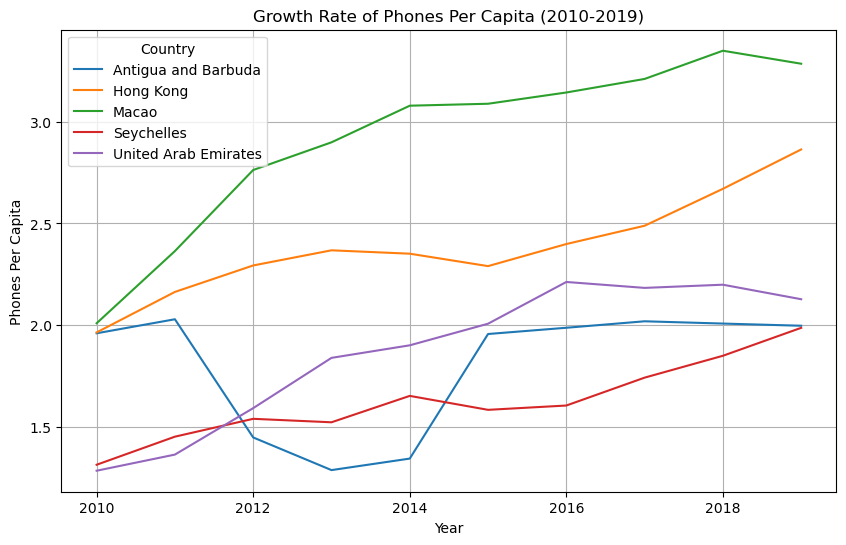

In [77]:
# Filter data for top countries by phones per capita in 2019
top_countries_2019 = (
    final_data[final_data["year"] == 2019]
    .sort_values(by="phones_per_capita", ascending=False)
    .head(5)
    .pivot(index="year", columns="name", values="phones_per_capita")
)

# Calculate growth rates over the last 10 years for these countries
growth_data = final_data[
    final_data["name"].isin(top_countries_2019.columns) & (final_data["year"] >= 2010)
]
growth_pivot = growth_data.pivot(index="year", columns="name", values="phones_per_capita")

# Select and display the required columns
table1 = final_data[["iso-3", "year", "n_cellphones", "population"]].sort_values(by=["year", "iso-3"]).head(10)
print("Table 1: Combined Data (First Few Rows)")
print(table1)

# Filter data for the years 2015–2019 and top 5 countries
top_countries = top_countries_2019.columns.tolist()  # List of top countries
table2 = final_data[
    final_data["name"].isin(top_countries) & (final_data["year"] >= 2015)
].pivot(index="year", columns="name", values="phones_per_capita")

# Display the table
print("Table 2: Phones Per Capita for Top Countries (2015–2019)")
print(table2)

# Plot growth rates
import matplotlib.pyplot as plt

growth_pivot.plot(figsize=(10, 6), title="Growth Rate of Phones Per Capita (2010-2019)")
plt.ylabel("Phones Per Capita")
plt.xlabel("Year")
plt.legend(title="Country")
plt.grid()
plt.show()

## SQL

Our goal in this task is to analyze the user_actions table in the SQLite database user_actions.db to do the following:

1. Retrieve the usernames of users who performed the "signup" action.
2. Find the total number of log entries for each user.
3. Identify users who logged in and signed up on the same day.

### Step 1

The sqlite3 module is used to connect to the database and execute queries.

Then we identify all users who performed the "signup" action. We use the WHERE clause to filter rows where the action column equals 'signup'.

In [80]:
import sqlite3
con = sqlite3.connect("user_actions.db")

# Create a cursor object
cur = con.cursor()

# Execute SQL query
cur.execute("SELECT username FROM user_actions WHERE action = 'signup';")

# Fetch all results
signup_usernames = cur.fetchall()

# Display results
print("Usernames who performed 'signup':")
for username in signup_usernames:
    print(username[0])

Usernames who performed 'signup':
user34
user28
user1
user24
user15
user20
user18
user25
user3
user9
user27
user16
user17
user4
user8
user13
user19
user31
user10
user23
user11
user33
user12
user29
user21
user6
user14
user30
user7
user26
user22
user5
user35
user2
user32


### Step 2

Here we calculate the total number of actions (log entries) performed by each user. We can use the GROUP BY clause to group rows by user_id and username. Then we use the COUNT(*) function to count the number of rows for each group.

In [83]:
# Execute SQL query
cur.execute("""
SELECT user_id, username, COUNT(*) AS log_entries
FROM user_actions
GROUP BY user_id, username;
""")

# Fetch all results
log_entries = cur.fetchall()

# Display results
print("Total number of log entries per user:")
for entry in log_entries:
    print(f"User ID: {entry[0]}, Username: {entry[1]}, Log Entries: {entry[2]}")

Total number of log entries per user:
User ID: 1, Username: user1, Log Entries: 104
User ID: 2, Username: user2, Log Entries: 149
User ID: 3, Username: user3, Log Entries: 108
User ID: 4, Username: user4, Log Entries: 436
User ID: 5, Username: user5, Log Entries: 192
User ID: 6, Username: user6, Log Entries: 457
User ID: 7, Username: user7, Log Entries: 362
User ID: 8, Username: user8, Log Entries: 329
User ID: 9, Username: user9, Log Entries: 118
User ID: 10, Username: user10, Log Entries: 170
User ID: 11, Username: user11, Log Entries: 328
User ID: 12, Username: user12, Log Entries: 209
User ID: 13, Username: user13, Log Entries: 470
User ID: 14, Username: user14, Log Entries: 320
User ID: 15, Username: user15, Log Entries: 35
User ID: 16, Username: user16, Log Entries: 379
User ID: 17, Username: user17, Log Entries: 367
User ID: 18, Username: user18, Log Entries: 122
User ID: 19, Username: user19, Log Entries: 58
User ID: 20, Username: user20, Log Entries: 362
User ID: 21, Username:

### Step 3

Here we find users who performed both a "login" and a "signup" action on the same day. We do a self-join on the user_actions table using user_id as the key to match rows for the same user. Then we use the WHERE clause to ensure one action is 'login' and the other is 'signup', and the DATE() function to extract the date part from the timestamp column and compare dates.

In [86]:
# Execute SQL query
cur.execute("""
SELECT DISTINCT ua1.user_id, ua1.username
FROM user_actions ua1
JOIN user_actions ua2
ON ua1.user_id = ua2.user_id
WHERE ua1.action = 'login'
  AND ua2.action = 'signup'
  AND DATE(ua1.timestamp) = DATE(ua2.timestamp);
""")

# Fetch all results
login_signup_users = cur.fetchall()

# Display results
print("Users who logged in and signed up on the same day:")
for user in login_signup_users:
    print(f"User ID: {user[0]}, Username: {user[1]}")

Users who logged in and signed up on the same day:
User ID: 8, Username: user8
User ID: 12, Username: user12
User ID: 30, Username: user30
User ID: 7, Username: user7
User ID: 22, Username: user22
User ID: 5, Username: user5
User ID: 2, Username: user2
User ID: 32, Username: user32


## Regex

We extract hashtags using a regular expression that matches words starting with # and followed by alphanumeric characters (letters, numbers, and underscores).

In [89]:
import re

# Example comment
comment = "Great stuff! #programming #tips"

# Extract hashtags
hashtags = re.findall(r"#\w+", comment)
print(hashtags)

['#programming', '#tips']


Here we use a regex pattern that ensures both hashtags are present in the comment. 

In [92]:
# Example comment 2
comment2 = "I am learning #programming in #python"

# Regular expression to check for both #programming and #python
pattern = r"(?=.*#programming)(?=.*#python)"

# Apply regex to check if both hashtags are present
match = re.search(pattern, comment2, re.IGNORECASE)

# Output the result
bool(match)


True

In [94]:
# Load comments file
with open('comments.txt', 'r') as file:
    comments = file.read()

# Extract all hashtags
all_hashtags = re.findall(r"#\w+", comments)

# Get unique hashtags
unique_hashtags = set(all_hashtags)
print(unique_hashtags)

{'#research', '#coding', '#analysis', '#data', '#python', '#innovation', '#insights', '#programming', '#tech', '#analytics', '#tips'}
